In [ ]:
### https://arxiv.org/pdf/1512.00567.pdf
### https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202
### https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py

## Implementation of

### a) Basic neural network blocks as functions
### b) Create simple module (inception & more) in tesorflow  
### c) Create a complex neural network (inception_v2) from scratch using simple modules  

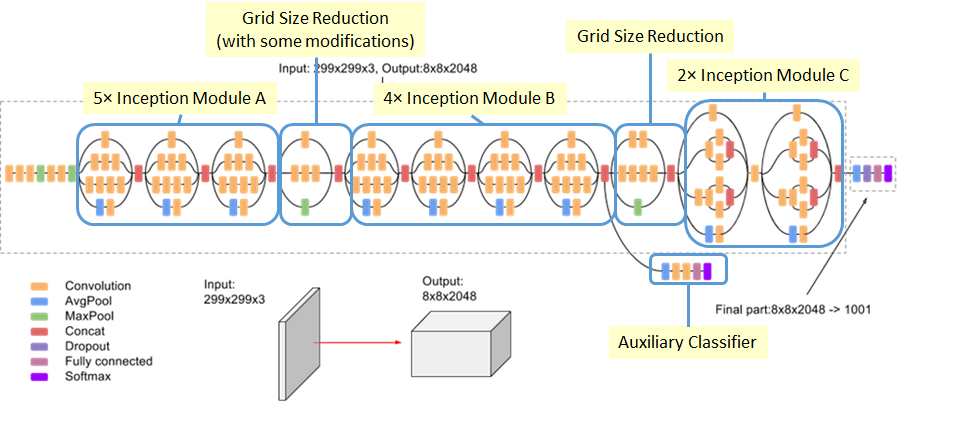

In [ ]:
import tensorflow as tf
import os
import cv2
import random
import numpy as np
activation_map = {'relu': tf.nn.relu}

In [ ]:
def CNN2D(input_data, 
          num_filters, 
          kernel, 
          strides=(1, 1), 
          padding="SAME", 
          use_bias=True, 
          activation='relu', 
          name='cnn2d'):
    
    """input_data = 4D Tensor (batch, rows, columns, channels)
    kernel = tuple  for filter kernel size (rows, columns)
    """
    with tf.variable_scope(name):
        input_data_chanel = input_data.get_shape().dims[3].value
        filter_shape = (kernel[0], kernel[1], input_data_chanel, num_filters)

        stride_shape = (1, strides[0], strides[1], 1)

        W = tf.get_variable("%s_cnnw"%(name), initializer=tf.glorot_uniform_initializer()(filter_shape))
        cnnout = tf.nn.conv2d(
                        input_data,
                        W,
                        strides=stride_shape,
                        padding=padding)
        if use_bias:
            b = tf.get_variable("%s_cnnb"%(name), initializer=tf.constant(0.2, shape=[num_filters]))
            cnnout = tf.nn.bias_add(cnnout, b)

        if activation and activation in activation_map:
            cnnout = activation_map[activation](cnnout)
    
    return tf.identity(cnnout, name="%s_cnnout"%name)

In [ ]:
def MaxPool2D(input_data, kernel, strides, padding='SAME', name=''):
    return tf.nn.max_pool(input_data,
                    ksize=(1, kernel[0], kernel[1], 1),
                    strides=(1, strides[0], strides[1], 1),
                    padding=padding,
                    name="%s_maxpool"%name)

In [ ]:
def fc(input_data, neurons, i=0 ,bais=False, activation="relu"):
    with tf.variable_scope("fc_%s"%i):
        input_dim = input_data.get_shape().as_list()[1]
        Weight_mat = tf.get_variable(
            "weight_mat_%s" % i,
            shape = [input_dim, neurons],
            initializer = tf.contrib.layers.xavier_initializer())
        
        bais_mat = tf.get_variable("bais_mat_%s" % i, initializer=tf.constant(0.1, shape=[neurons]))
        fc_output = tf.nn.xw_plus_b(input_data, Weight_mat, bais_mat)
        if activation and activation in activation_map:
            fc_output = activation_map[activation](fc_output)
    return tf.identity(fc_output, name="fc_%s"%i)

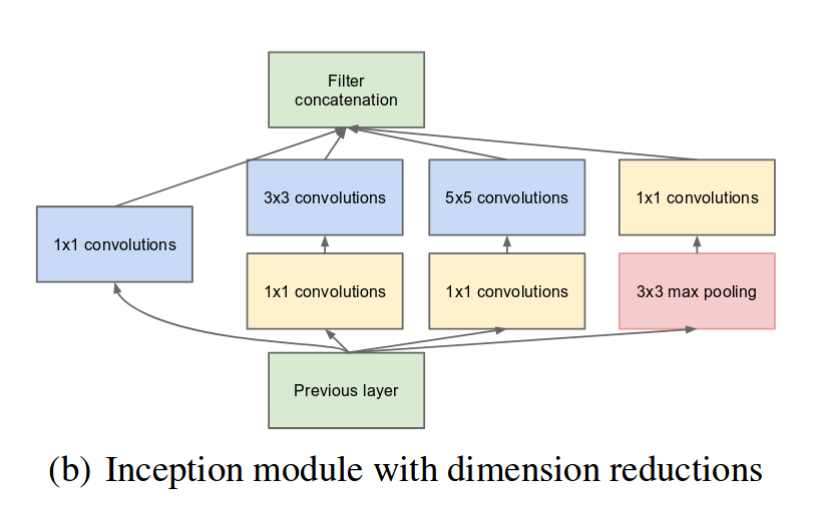

In [ ]:
def inception_aux_logits(input_data,
                        filters_1x1=128,
                        filters_5x5=768,
                        name="aux_logits"):
    
    with tf.variable_scope(name):
        max_pool_5x5 =  MaxPool2D(input_data, (5, 5), strides=(3, 3), padding="VALID", name="max_pool_5x5")
        conv_1x1 = CNN2D(max_pool_5x5, filters_1x1, (1, 1), name="conv_1x1")
        conv_5x5 = CNN2D(conv_1x1, filters_5x5, (5, 5), padding="VALID", name="conv_5x5")
        
        net = tf.reduce_mean(conv_5x5, (1, 2))
    return net

In [ ]:
def inception_v1_module(input_data,
                     filters_1x1,
                     filters_3x3_1x1,
                     filters_3x3,
                     filters_5x5_1x1,
                     filters_5x5,
                     filters_1x1_pool,
                     name='inception_v1'):
    with tf.variable_scope(name):
        conv_1x1 = CNN2D(input_data, filters_1x1, (1, 1), name="conv_1x1")

        conv_3x3_1x1 = CNN2D(input_data, filters_3x3_1x1, (1, 1), name="conv_3x3_1x1")
        conv_3x3 = CNN2D(conv_3x3_1x1, filters_3x3, (3, 3), name="conv_3x3")

        conv_5x5_1x1 = CNN2D(input_data, filters_5x5_1x1, (1, 1), name="conv_5x5_1x1")
        conv_5x5 = CNN2D(conv_5x5_1x1, filters_5x5, (5, 5), name="conv_5x5")

        max_pool_3x3 = MaxPool2D(input_data, (3, 3), strides=(1, 1), name="max_pool_3x3")
        conv_1x1_pool = CNN2D(max_pool_3x3, filters_1x1_pool, (1, 1))

        output = tf.concat([conv_1x1, conv_3x3, conv_5x5, conv_1x1_pool], axis=3, name="output")
    
    return output

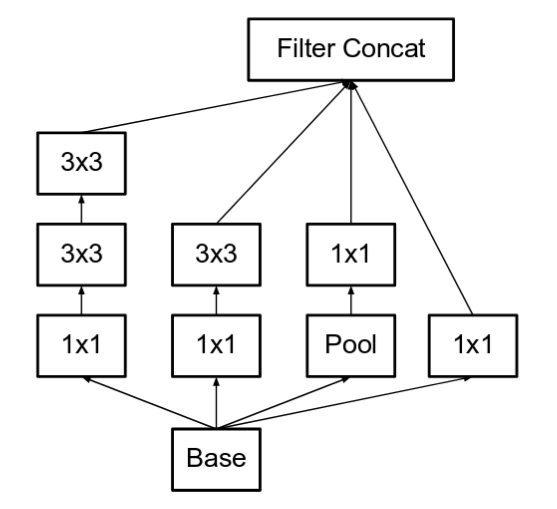

In [ ]:
def inception_A(input_data,
                 filters_1x1=64,
                 filters_3x3_1x1=48,
                 filters_3x3=64,
                 filters_5x5_1x1=64,
                 filters_5x5=96,
                 filters_1x1_pool=32,
                 name="inception_a"):
    with tf.variable_scope(name):
        conv_1x1 = CNN2D(input_data, filters_1x1, (1, 1), name="conv_1x1")

        conv_3x3_1x1 = CNN2D(input_data, filters_3x3_1x1, (1, 1), name="conv_3x3_1x1")
        conv_3x3 = CNN2D(conv_3x3_1x1, filters_3x3, (3, 3), name="conv_3x3")

        conv_5x5_1x1 = CNN2D(input_data, filters_5x5_1x1, (1, 1), name="conv_5x5_1x1")
        conv_5x5_a = CNN2D(conv_5x5_1x1, filters_5x5, (3, 3), name="conv_5x5_a")
        conv_5x5_b = CNN2D(conv_5x5_a, filters_5x5, (3, 3), name="conv_5x5_b")

        max_pool_3x3 = MaxPool2D(input_data, (3, 3), strides=(1, 1), name="max_pool_3x3")
        conv_1x1_pool = CNN2D(max_pool_3x3, filters_1x1_pool, (1, 1))

        output = tf.concat([conv_1x1, conv_3x3, conv_5x5_b, conv_1x1_pool], axis=3, name="output")
    
    return output

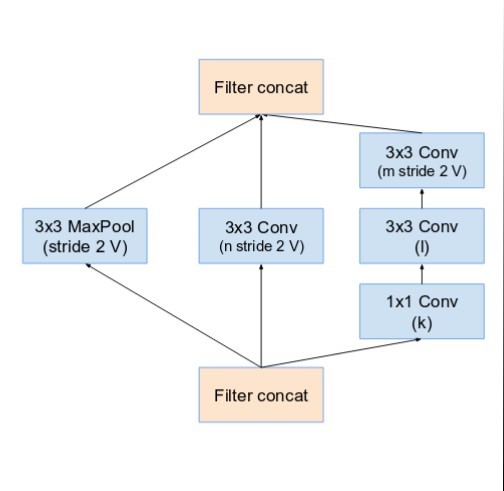

In [ ]:
def inception_B(input_data,
                 filters_3x3=384,
                 filters_7x7_split_1x1=64,
                 filters_7x7_split=96,
                 name="inception_b"):
    with tf.variable_scope(name):
        conv_3x3 = CNN2D(input_data, filters_3x3, (3, 3), (2, 2), padding="VALID", name="conv_1x1")

        conv_7x7_split_1x1 = CNN2D(input_data, filters_7x7_split_1x1, (1, 1), name="conv_7x7_split_1x1")
        conv_7x7_split_a = CNN2D(conv_7x7_split_1x1, filters_7x7_split, (3, 3), name="conv_7x7_split_a")
        conv_7x7_split_b = CNN2D(conv_7x7_split_a, filters_7x7_split, (3, 3), strides=(2, 2), padding="VALID", name="conv_7x7_split_b")

        max_pool_3x3 = MaxPool2D(input_data, (3, 3), strides=(2, 2), padding="VALID", name="max_pool_3x3")

        output = tf.concat([conv_3x3, conv_7x7_split_b, max_pool_3x3], axis=3, name="output")
    
    return output

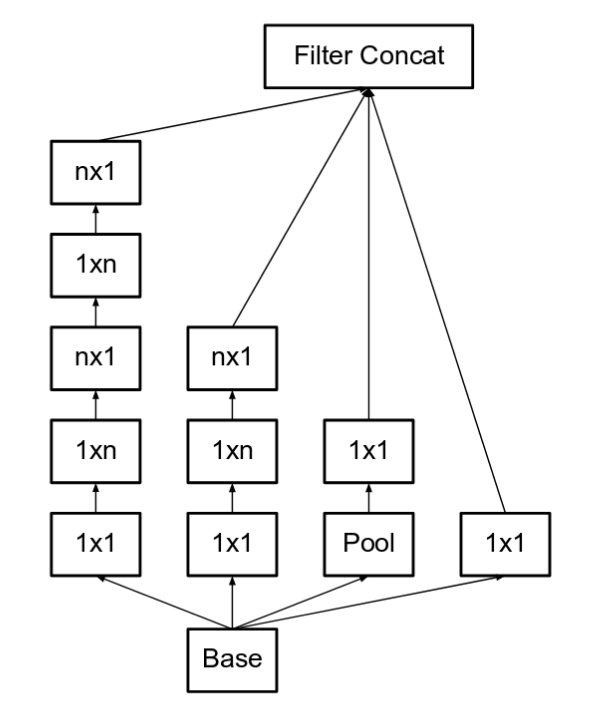

In [ ]:
def inception_C(input_data,
                 filters_1x1=192,
                 filters_7x7_1x1=128,
                 filters_7x7=128,
                 name="inception_c"):
    with tf.variable_scope(name):
        conv_1x1 = CNN2D(input_data, filters_1x1, (1, 1), name="conv_1x1")


        conv_b1_7x7_1x1 = CNN2D(input_data, filters_7x7_1x1, (1, 1), name="conv_b1_7x7_1x1")
        conv_b1_7x7_a = CNN2D(conv_b1_7x7_1x1, filters_7x7_1x1, (1, 7), name="conv_b1_7x7_a")
        conv_b1_7x7_b = CNN2D(conv_b1_7x7_a, filters_7x7, (7, 1), name="conv_b1_7x7_b")

        conv_b2_7x7_1x1 = CNN2D(input_data, filters_7x7_1x1, (1, 1), name="conv_b2_7x7_1x1")
        conv_b2_7x7_a = CNN2D(conv_b2_7x7_1x1, filters_7x7_1x1, (7, 1), name="conv_b2_7x7_a")
        conv_b2_7x7_b = CNN2D(conv_b2_7x7_a, filters_7x7, (1, 7), name="conv_b2_7x7_b")
        conv_b2_7x7_c = CNN2D(conv_b2_7x7_b, filters_7x7_1x1, (7, 1), name="conv_b2_7x7_c")
        conv_b2_7x7_d = CNN2D(conv_b2_7x7_c, filters_7x7, (1, 7), name="conv_b2_7x7_d")    

        max_pool_3x3 = MaxPool2D(input_data, (3, 3), strides=(1, 1), name="max_pool_3x3")
        conv_1x1_pool = CNN2D(max_pool_3x3, filters_7x7, (1, 1))

        output = tf.concat([conv_1x1, conv_b1_7x7_b, conv_b2_7x7_d, conv_1x1_pool], axis=3, name="output")
    
    return output

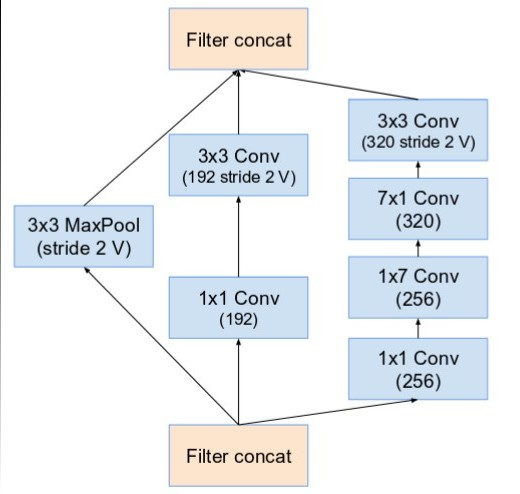

In [ ]:
def inception_D(input_data,
                 filters_3x3_1x1=192,
                 filters_3x3=320,
                 filters_7x7x3=192,
                 name="inception_d"):
    with tf.variable_scope(name):
        conv_3x3_1x1 = CNN2D(input_data, filters_3x3_1x1, (1, 1), name="conv_3x3_1x1")
        conv_3x3 = CNN2D(conv_3x3_1x1, filters_3x3, (3, 3), strides=(2, 2), padding="VALID", name="conv_3x3")

        conv_7x7x3_a = CNN2D(input_data, filters_7x7x3, (1, 1), name="conv_7x7x3_a")
        conv_7x7x3_b = CNN2D(conv_7x7x3_a, filters_7x7x3, (1, 7), name="conv_7x7x3_b")
        conv_7x7x3_c = CNN2D(conv_7x7x3_b, filters_7x7x3, (7, 1), name="conv_7x7x3_c")
        conv_7x7x3_d = CNN2D(conv_7x7x3_c, filters_7x7x3, (3, 3), (2, 2), padding="VALID", name="conv_7x7x3_d")

        max_pool_3x3 = MaxPool2D(input_data, (3, 3), strides=(2, 2), padding="VALID", name="max_pool_3x3")

        output = tf.concat([conv_3x3, conv_7x7x3_d, max_pool_3x3], axis=3, name="output")

    return output

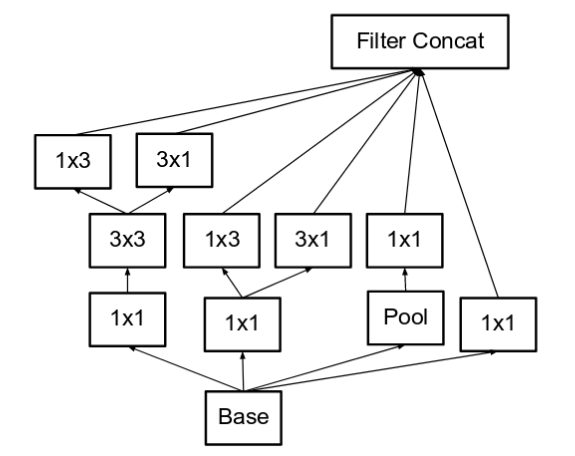

In [ ]:
def inception_E(input_data,
                 filters_1x1=320,
                 filters_b1_3x3=384,
                 filters_b2_3x3_1x1=448,
                 filters_b2_3x3=384,
                 filters_1x1_pool=192,
                 name="inception_e"):
    with tf.variable_scope(name):
        conv_1x1 = CNN2D(input_data, filters_1x1, (1, 1), name="conv_1x1")


        conv_b1_3x3_1x1 = CNN2D(input_data, filters_b1_3x3, (1, 1), name="conv_b1_3x3_1x1")
        
        conv_b1_3x3_a = CNN2D(conv_b1_3x3_1x1, filters_b1_3x3, (1, 3), name="conv_b1_3x3_a")
        conv_b1_3x3_b = CNN2D(conv_b1_3x3_1x1, filters_b1_3x3, (3, 1), name="conv_b1_3x3_b")
        conv_b1_3x3 = tf.concat([conv_b1_3x3_a, conv_b1_3x3_b], axis=3, name="conv_b1_3x3")
        
        conv_b2_3x3_1x1 = CNN2D(input_data, filters_b2_3x3_1x1, (1, 1), name="conv_b2_3x3_1x1")
        conv_b2_3x3_a = CNN2D(conv_b2_3x3_1x1, filters_b2_3x3, (3, 3), name="conv_b2_3x3_a")
        
        conv_b2_3x3_b = CNN2D(conv_b2_3x3_a, filters_b2_3x3, (3, 1), name="conv_b2_3x3_b")
        conv_b2_3x3_c = CNN2D(conv_b2_3x3_a, filters_b2_3x3, (1, 3), name="conv_b2_3x3_c")
        conv_b2_3x3 = tf.concat([conv_b2_3x3_b, conv_b2_3x3_c], axis=3, name="conv_b2_3x3")
        
        max_pool_3x3 = MaxPool2D(input_data, (3, 3), strides=(1, 1), name="max_pool_3x3")
        conv_1x1_pool = CNN2D(max_pool_3x3, filters_1x1_pool, (1, 1))

        output = tf.concat([conv_1x1, conv_b1_3x3, conv_b2_3x3, conv_1x1_pool], axis=3, name="output")
    
    return output

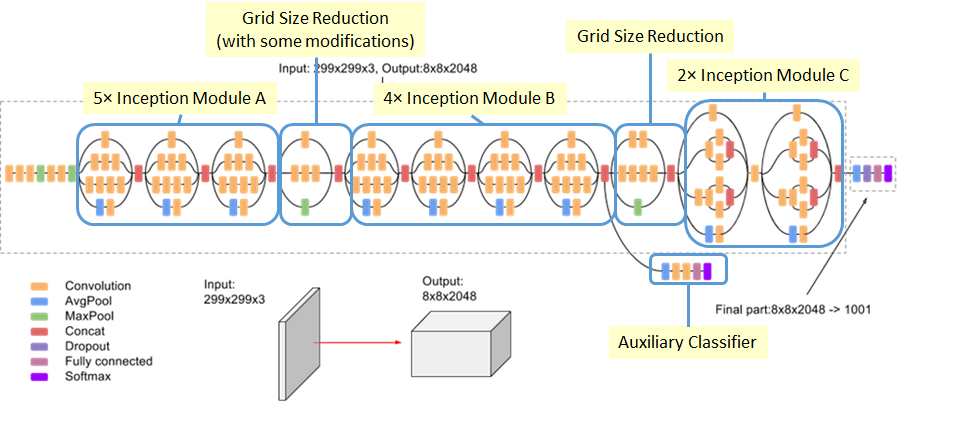

In [ ]:
class inception_v2():
    def __init__(self, is_aux_logits=True):
        self._is_aux_logits = is_aux_logits
    
    def create_model(self, images_tensor, final_endpoint="Mixed_7c"):
        print ("0 : ",images_tensor.get_shape())
#         net = CNN2D(images_tensor, 64, (7, 7), strides=(2, 2), padding="VALID", name="Conv2d_1a_7x7")
#         print ("1 : ",net.get_shape())
        
        layer_name = "Conv2d_1a_7x7_a"
        net = CNN2D(images_tensor, 32, (3, 3), strides=(2, 2), padding="VALID", name=layer_name)
        print ("1_ : ",net.get_shape())
        
        layer_name = "Conv2d_1a_7x7_b"
        net = CNN2D(net, 32, (3, 3), strides=(1, 1), padding="VALID",  name=layer_name)
        print ("2_ : ",net.get_shape())
        
        layer_name = "Conv2d_1a_7x7"
        net = CNN2D(net, 64, (3, 3), strides=(1, 1), name=layer_name)
        print ("1 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "MaxPool_2a_3x3"
        net = MaxPool2D(net, (3, 3), (2, 2), padding="VALID", name=layer_name)
        print ("2 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Conv2d_2b_3x3"
        net = CNN2D(net, 80, (3, 3), padding="VALID", name=layer_name)
        print ("3 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Conv2d_3b_3x3"
        net = CNN2D(net, 192, (3, 3), (2, 2), padding="VALID", name=layer_name)
        print ("4 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Conv2d_4a_3x3"
        net = CNN2D(net, 288, (3, 3), name=layer_name)
        print ("5 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_5b"
        net = inception_A(net, filters_1x1_pool=32, name=layer_name)
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_5c"
        net = inception_A(net, filters_1x1_pool=64, name=layer_name)
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_5d"
        net = inception_A(net, filters_1x1_pool=64, name=layer_name)
        print ("6 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_6a"
        net = inception_B(net, name=layer_name)
        print ("7 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_6b"
        net = inception_C(net, filters_7x7_1x1=128, filters_7x7=128, name=layer_name)
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_6c"
        net = inception_C(net, filters_7x7_1x1=160, filters_7x7=160, name=layer_name)
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_6d"
        net = inception_C(net, filters_7x7_1x1=160, filters_7x7=160, name=layer_name)
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        layer_name = "Mixed_6e"
        net = inception_C(net, filters_7x7_1x1=192, filters_7x7=192, name=layer_name)
        print ("8 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), None
        
        
        if self._is_aux_logits:
            aux_logits_net = inception_aux_logits(net)
            print ("aux : ",aux_logits_net.get_shape())
            if final_endpoint == "aux": return  aux_logits_net, None
        else:
            aux_logits_net = None
            
        layer_name = "Mixed_7a"
        net = inception_D(net, name=layer_name)
        print ("9 : ",net.get_shape())
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), aux_logits_net
        
        layer_name = "Mixed_7b"
        net = inception_E(net, name=layer_name)
        if final_endpoint == layer_name: return tf.reduce_mean(net, (1, 2)), aux_logits_net
        
        layer_name = "Mixed_7c"
        net = inception_E(net, name=layer_name)
        print ("10 : ",net.get_shape())
        
        return tf.reduce_mean(net, (1, 2)), aux_logits_net
        

In [ ]:
class ImageClassification():
    def __init__(self, num_classes, inception_endpoint="Mixed_7c", is_aux_logits=True):
        self._num_classes = num_classes
        self.inception_v2_class = inception_v2(is_aux_logits)
        
        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        
        self.is_aux_logits = False
        self.model_inputs()
        self.create_model(inception_endpoint)
        self.loss_fn()
        self.create_train_op()
        self.calculate_accuracy()    
    
    def model_inputs(self):
        self.images_tensor = tf.placeholder(tf.float32, (None, 299, 299, 3))
        self.input_y = tf.placeholder(tf.float32, (None, self._num_classes))
        
    def create_model(self, inception_endpoint):
        net,  aux_logits_net = self.inception_v2_class.create_model(self.images_tensor, 
                                                                    final_endpoint=inception_endpoint)
        print ("11 : ",net.get_shape())
        
        with tf.variable_scope("fc_layer", reuse=tf.AUTO_REUSE):
            self.logits = fc(net, self._num_classes, i="output", bais=True, activation=None)
            print ("12 : ",self.logits.get_shape())
            
            if aux_logits_net is not None:
                self.is_aux_logits = True
                self.aux_logits = fc(aux_logits_net, self._num_classes, i="aux_outout", bais=True, activation=None)
                print ("13 : ",self.aux_logits.get_shape())
            
    
    def loss_fn(self):
        loss_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.input_y, 
                                                                                      logits=self.logits))
        aux_loss = tf.constant(0, dtype=tf.float32)
        if self.is_aux_logits:
            aux_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.input_y, 
                                                                                        logits=self.aux_logits))
        self.loss = loss_ + 0.5*aux_loss
        
    def create_train_op(self, initial_learning_rate=0.001):
        learning_rate = tf.train.exponential_decay(initial_learning_rate, self.global_step,
                                           1000, 0.75, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train_op = optimizer.minimize(self.loss, global_step=self.global_step)
    
    def calculate_accuracy(self):
        predictions_bool = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.input_y, 1), name="predictions")
        self.predictions = tf.cast(predictions_bool, tf.float32)
        self.accuracy = tf.reduce_mean(self.predictions, name="accuracy")
        
    
    def train_step(self, sess, image_tensor_batch, input_y_batch, writer=None):
        feed_dict = {
            self.images_tensor: image_tensor_batch,
            self.input_y: input_y_batch,
            }
        _, step, loss = sess.run(
                [self.train_op, self.global_step, self.loss],
                feed_dict)
        
        if step%1==0:
            print("Training :: step %d, loss %f"%(step, loss))

        if writer:
            writer.add_summary(summaries, step)
        return step, loss
    
    def dev_step(self, sess, image_tensor_batch, input_y_batch, writer=None):
        feed_dict = {
            self.images_tensor: image_tensor_batch,
            self.input_y: input_y_batch,
            }
        step, loss, predictions, accuracy = sess.run(
            [self.global_step, self.loss, self.predictions, self.accuracy],
            feed_dict)
        
        print("Testing :: step %d, loss %f, acc %f"%(step, loss, accuracy))
        if writer:
            writer.add_summary(summaries, step)
        return step, predictions, accuracy

## Data Processing

In [ ]:
base_folder = "./resized_flower_photos/"

all_labels = sorted([f for f in os.listdir(base_folder) if not f.startswith(".")])
label_mapping = {label: i for i, label in enumerate(all_labels)}

label_file = "./label.txt"
with open(label_file, 'wb') as thefile:
    thefile.write("\n".join(all_labels))

In [ ]:
def split_train_test(image_list, fraction=0.1):
    random.shuffle(image_list)
    n = int(fraction*len(image_list))
    return image_list[n:], image_list[:n]

In [ ]:
def get_train_test_data():
    train_images = []
    test_images = []
    
    for label in all_labels:
        label_folder = os.path.join(base_folder, label)
        label_train_images = [f for f in os.listdir(label_folder) if f.endswith(".jpg")]
        test_folder = os.path.join(label_folder, 'test')
        if not os.path.isdir(test_folder):
            os.makedirs(test_folder)
            
        label_test_images = [f for f in os.listdir(test_folder) if f.endswith(".jpg")]
        
        if not label_test_images:
            label_train_images, label_test_images = split_train_test(label_train_images)
            for img in label_test_images:
                src = os.path.join(label_folder, img)
                dst = os.path.join(test_folder, img)
                os.rename(src, dst)
        for img in label_train_images:
            img_full_path = os.path.join(label_folder, img)
            train_images.append([img_full_path, label_mapping[label]])
        
        for img in label_test_images:
            img_full_path = os.path.join(test_folder, img)
            test_images.append([img_full_path, label_mapping[label]])
        print(label, len(label_train_images), len(label_test_images))
        
    return train_images, test_images

In [ ]:
def process_batch_data(batch_data_list):
    batch_images_np = []
    batch_gt = []
    for img, label in batch_data_list:
        batch_images_np.append(cv2.imread(img))
        batch_gt.append(label)
    return np.array(batch_images_np), np.array(batch_gt)
def batch_iter(data_list, batch_size=16, shuffle=True):
    if shuffle:
        random.shuffle(data_list)
    
    while len(data_list) > 0:
        batch_data_list, data_list = data_list[:batch_size], data_list[batch_size:]
        yield process_batch_data(batch_data_list)

In [ ]:
def convert_to_one_hot(np_array, vec_len):
    one_hot = np.zeros((len(np_array), vec_len))
    one_hot[np.arange(len(np_array)), np_array] = 1
    return one_hot

In [ ]:
train_images, test_images = get_train_test_data()
num_classes = len(all_labels)

## Training

In [ ]:
sess = tf.Session()

print("====creating model=====")
image_classification_model = ImageClassification(num_classes)

In [ ]:
saver = tf.train.Saver(tf.global_variables())
sess.run(tf.global_variables_initializer())
checkpoint_prefix = "./checkpoints/model"

In [ ]:
best_accuracy = 0
num_of_epoches = 100
print("training started")
for epoch in range(num_of_epoches):
    train_batches = batch_iter(train_images, batch_size=64)
    for batch in train_batches:
        batch_images, batch_gt = batch
        batch_gt_onehot = convert_to_one_hot(batch_gt, num_classes)
        step, loss = image_classification_model.train_step(sess, batch_images, batch_gt_onehot)
        
        if step%2 == 0:
            print("Testing after %d step"%(step))
            test_batches = batch_iter(test_images, batch_size=len(test_images))
            for test_batch in test_batches:
                batch_images, batch_gt = test_batch
                batch_gt_onehot = convert_to_one_hot(batch_gt, num_classes)
                step, predictions, accuracy = image_classification_model.dev_step(sess, batch_images, batch_gt_onehot)
                
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                saver.save(sess, checkpoint_prefix, global_step=step)
    
    print("Testing after %d epoche"%(epoch))
    test_batches = batch_iter(test_images, batch_size=len(test_images))
    for test_batch in test_batches:
        batch_images, batch_gt = test_batch
        batch_gt_onehot = convert_to_one_hot(batch_gt, num_classes)
        step, predictions, accuracy = image_classification_model.dev_step(sess, batch_images, batch_gt_onehot)